# 1. Introduction

## Predict the Introverts from the Extroverts Using TensorFlow

## Objective
The objective of this project is to build a machine learning model using the TensorFlow library to predict whether a person is an introvert or extrovert based on various social and behavioral characteristics. The dataset used for this project is provided by the Kaggle competition.

## Dataset Description
The dataset contains the following columns:

- **id**: Unique identifier for each entry.
- **Time_spent_Alone**: Time the person spends alone, in hours.
- **Stage_fear**: Indicates if the person has a fear of speaking in public (yes or no).
- **Social_event_attendance**: Number of social events attended by the person.
- **Going_outside**: Number of times the person goes outside.
- **Drained_after_socializing**: Indicates if the person feels drained after socializing (yes or no).
- **Friends_circle_size**: Size of the person's circle of friends.
- **Post_frequency**: Frequency of posts on social media.
- **Personality**: The target class, indicating if the person is "Introvert" or "Extrovert".

## Notebook Structure
The notebook will be structured as follows:

1. **Importing Libraries**: We will load necessary libraries such as TensorFlow and Matplotlib.
2. **Loading Data**: We will read the CSV dataset and display a sample.
3. **Data Preprocessing**: 
   - We will check for and handle missing data.
   - Convert categorical variables to numerical format.
   - Split the data into training and validation sets.
4. **Model Building**: We will use TensorFlow's Keras API to create and compile a neural network model.
5. **Model Training**: We will train the model using the training dataset and validate its performance.
6. **Model Evaluation**: We will assess the model's performance using appropriate metrics such as accuracy, recall, and F1-score.
7. **Predictions**: We will use the trained model to make predictions on new data.

## Conclusion
By the end of this notebook, we aim to have an effective model capable of accurately predicting personality traits based on the provided features. This project will allow us to explore the TensorFlow library and apply machine learning techniques to a real-world problem.

# 2. Imports

In [1]:
%%time
# Cell 1: Import Libraries
import os  # For operating system functionalities
import pandas as pd  # For data manipulation and analysis with DataFrames
import numpy as np  # For numerical operations on arrays and matrices
from sklearn.preprocessing import LabelEncoder  # For encoding categorical variables
from sklearn.experimental import enable_iterative_imputer  # Needed to use IterativeImputer
from sklearn.impute import IterativeImputer  # For iterative imputation of missing values
from sklearn.preprocessing import MinMaxScaler, RobustScaler  # For scaling feature values
from sklearn.decomposition import TruncatedSVD  # For dimensionality reduction
from sklearn.utils import resample  # For resampling methods
import matplotlib.pyplot as plt  # For data visualization
import tensorflow as tf  # For building and training the model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-07-07 05:13:42.682133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751865222.892004      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751865222.957144      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


CPU times: user 9.6 s, sys: 1.66 s, total: 11.3 s
Wall time: 17.4 s


# 3. Tensor Flow Information

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.18.0
Eager execution: True


# 4. Define Preprocessing Function

This cell defines the `preprocess` function, which is responsible for cleaning and transforming the dataset prior to model training. The function performs the following operations:

1. **Copying the DataFrame**: It creates a copy of the input DataFrame to avoid modifying the original data.

2. **Handling Missing Values**:
   - **Categorical Variables**: It fills missing values in the `Stage_fear` and `Drained_after_socializing` columns with a designated default value `'Unknown'`.
   - The categorical values (`'Yes'`, `'No'`, and `'Unknown'`) are mapped to numerical values (1, 0, -1) for ease of processing during model training.

3. **Imputation of Numeric Values**: The function identifies numeric columns (like `Time_spent_Alone`, `Social_event_attendance`, etc.) and uses an `IterativeImputer` to predict and fill in missing values based on other observed data in the DataFrame. This approach statistically estimates more accurate values for missing entries.

4. **Return Value**: The function returns the modified DataFrame containing completed numeric and encoded categorical values.

By preparing the dataset in this way, we ensure that it is ready for further processing and training in machine learning workflows.

In [3]:
def preprocess(df):
    # Make a copy of the DataFrame to avoid modifying the original data
    df = df.copy()
    
    # Map categorical variables to numerical values
    df['Stage_fear'] = df['Stage_fear'].fillna('Unknown').map({'Yes': 1, 'No': 0, 'Unknown': -1})
    df['Drained_after_socializing'] = df['Drained_after_socializing'].fillna('Unknown').map({'Yes': 1, 'No': 0, 'Unknown': -1})
    
    # Select numeric columns for imputation
    num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
    
    # Use IterativeImputer to fill missing numeric values
    imputer = IterativeImputer(random_state=42)
    df[num_cols] = imputer.fit_transform(df[num_cols])
    
    return df

# 5. Load the Datasets

In this cell, the training and testing datasets are loaded into the environment using Pandas. The following actions are performed:

1. **Loading Data**: The training dataset (`train.csv`) and the testing dataset are read from the specified file paths using `pd.read_csv()`.

2. **Data Verification**: The first few rows of each dataset are displayed using `display()` to confirm that the data has been loaded correctly. This method provides a clearer and more visually understandable format, enhancing the inspection of the structure and contents of the data.

By loading the datasets, we can then proceed to preprocess the data for feature extraction and model training.

In [4]:
# Cell 5: Load the Datasets

# Load the dataset
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')

# Cell 6: Preprocess Training and Test Data

In this cell, both the training and test datasets are preprocessed using the defined `preprocess` function. The following actions are performed:

1. **Preprocessing Training Data**:
   - The `preprocess` function is applied to the training dataset after dropping the columns 'id' and 'Personality'. The target variable (`y`) is extracted and mapped to integers (0 for Introvert and 1 for Extrovert).

2. **Preprocessing Test Data**:
   - The test dataset is also preprocessed by dropping the 'id' column.

3. **Missing Values Verification**:
   - After preprocessing both datasets, the code checks for any remaining missing values in the features using `display()`. This provides a clearer and more organized view of the missing data, ensuring the datasets are clean and ready for modeling.

This step prepares the data for subsequent analysis and modeling phases.

In [5]:
# Adjustable parameters
BATCH_SIZE = 64  # Increased batch size to stabilize training and leverage better GPU utilization
EPOCHS = 50  # Increased number of epochs for more training iterations to learn complex patterns
DROPOUT_RATE = 0.4  # Slightly increased dropout rate for regularization to help with overfitting
HIDDEN_UNITS_1 = 128  # Increased the number of neurons in the first hidden layer to allow the model to learn more complex features
HIDDEN_UNITS_2 = 64  # Increased the number of neurons in the second hidden layer for added complexity
HIDDEN_UNITS_3 = 32 # Increased the number of neurons in the second hidden layer for added complexity
VALIDATION_SPLIT = 0.2  # Keeps the same validation split for assessing performance

# Preprocess training data
# First, store the target variable
y = train['Personality'].map({'Introvert': 0, 'Extrovert': 1})  # Target variable

# Now drop the 'id' and 'Personality' columns to focus on features
train_features = train.drop(['id', 'Personality'], axis=1)  # Removing 'Personality'

# Call the preprocessing function to process features including new features
X = preprocess(train_features)  

# Preprocess test data
X_test = preprocess(test.drop('id', axis=1))  # Removing 'id' before preprocessing

# Scale the training data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Fit to training data (includes new features)
X_test_scaled = scaler.transform(X_test)  # Transform the test data with the same scaler

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y.values, test_size=VALIDATION_SPLIT, random_state=42)

# Create TensorFlow Dataset for the training and validation sets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)

# Model definition with Dropout for regularization
input_shape = X_scaled.shape[1]
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_shape,)),
    tf.keras.layers.Dense(HIDDEN_UNITS_1, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT_RATE),  
    # tf.keras.layers.Dense(HIDDEN_UNITS_2, activation='relu'),
    # tf.keras.layers.Dropout(DROPOUT_RATE),
    # tf.keras.layers.Dense(HIDDEN_UNITS_3, activation='relu'),
    # tf.keras.layers.Dropout(DROPOUT_RATE),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # For binary classification
              metrics=['accuracy'])

# Train the model with validation
history = model.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset)

# Make predictions on the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices(X_test_scaled).batch(BATCH_SIZE)  # No labels for test set
predictions = model.predict(test_dataset)
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to class labels


I0000 00:00:1751865237.174537      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751865237.175257      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1751865239.986216      62 service.cc:148] XLA service 0x7aa37c00b0d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751865239.987037      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751865239.987055      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751865240.224876      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


 71/232 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7545 - loss: 0.5561

I0000 00:00:1751865241.223872      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8548 - loss: 0.4008 - val_accuracy: 0.9687 - val_loss: 0.1475
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9666 - loss: 0.1574 - val_accuracy: 0.9687 - val_loss: 0.1444
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9662 - loss: 0.1539 - val_accuracy: 0.9687 - val_loss: 0.1432
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.1524 - val_accuracy: 0.9687 - val_loss: 0.1425
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9664 - loss: 0.1541 - val_accuracy: 0.9687 - val_loss: 0.1419
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9662 - loss: 0.1505 - val_accuracy: 0.9687 - val_loss: 0.1415
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9665 - loss: 0.1505 - val_accuracy: 0.9687 - val_loss: 0.1411
Epoch 8/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9667 - loss: 0.1504 - val_accuracy: 0.9687 - val_

# Cell 7: Visualize Training History

In this cell, we define the `plot_training_history` function to visualize the training progress of the model over epochs. This visualization will help in understanding how the model's performance evolves during training.

### Key Components:

1. **Function Definition**: 
   - The `plot_training_history` function takes in the training history object from `model.fit()` as an argument.

2. **Loss Visualization**: 
   - The first subplot displays the training loss across epochs. Monitoring the loss helps determine if the model is learning effectively.

3. **Accuracy Visualization**:
   - The second subplot presents the training accuracy over epochs. This information is crucial for evaluating how well the model predicts the target classes.

4. **Subplots**:
   - Both loss and accuracy are plotted on the same figure, allowing for easy comparison of how changes in loss relate to accuracy improvements.

5. **Display**: 
   - The function uses `plt.show()` to render the plots, aiding in visual assessment of the model's performance.

This step is critical for identifying potential issues such as overfitting or underfitting in the training process.

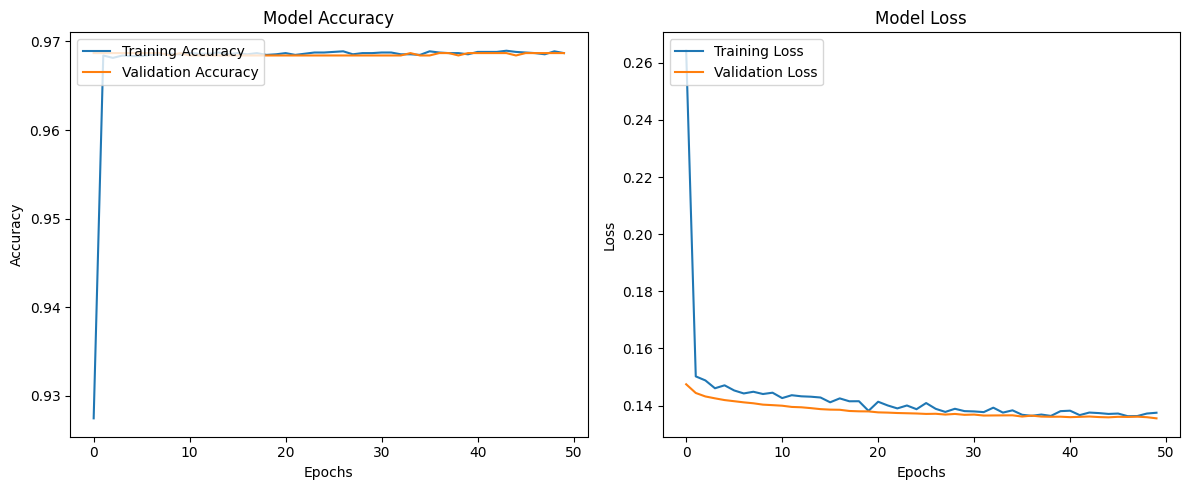

In [6]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Make predictions on the test dataset continues as is...

In [7]:
# Convert probabilities to class labels
predicted_classes = (predictions > 0.5).astype(int).flatten()  # Convert probabilities to binary class labels

# Display the first few predicted classes
print("Sample Predictions from Test Data (first 5):", predicted_classes[:5])

# Optional: Save Predictions to a CSV File
output_df = pd.DataFrame({'id': test['id'], 'Personality': predicted_classes})
output_df['Personality'] = output_df['Personality'].map({0: 'Introvert', 1: 'Extrovert'})  # Map back to original labels

# Save to CSV file
output_df.to_csv('submission.csv', index=False)  # Save the predictions for submission or review

Sample Predictions from Test Data (first 5): [1 0 1 1 0]


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


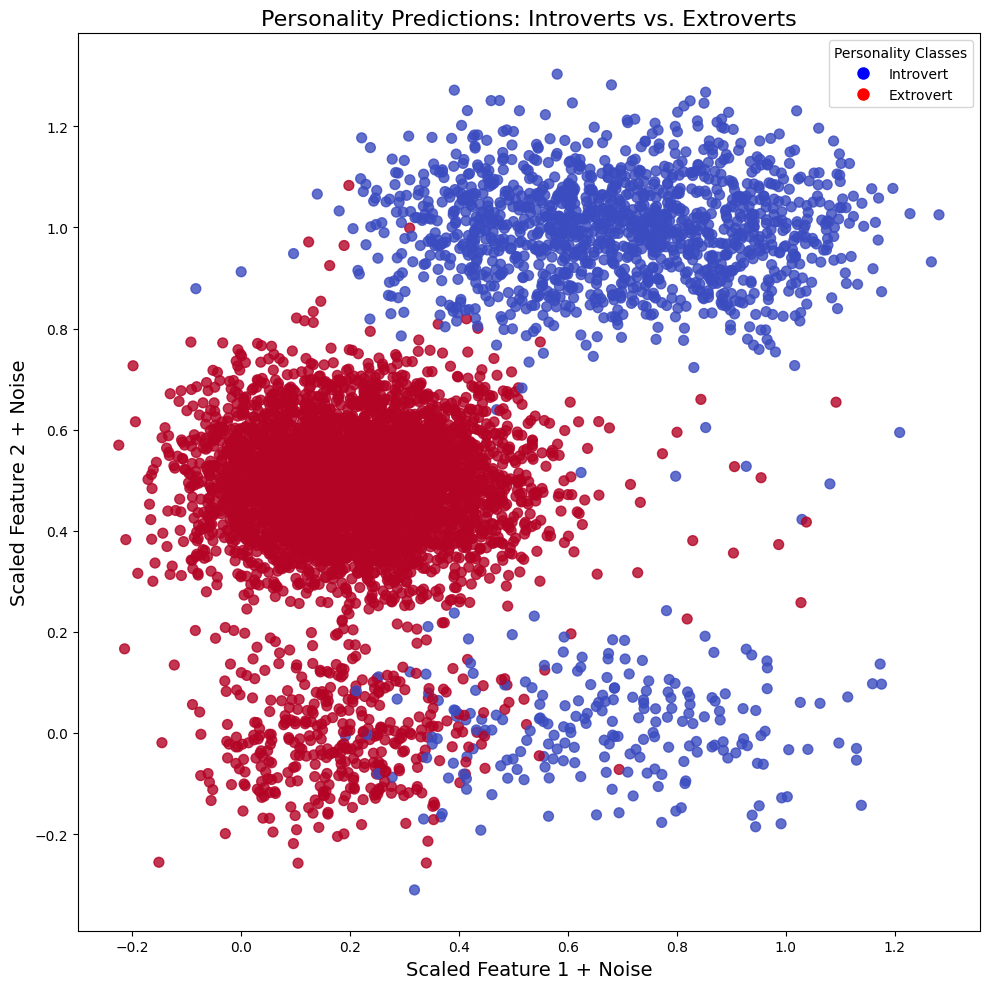

In [8]:
# Cell 9: Visualize Predictions
# Predict the probabilities for the test data
predictions = model.predict(test_dataset)  # This should give you the prediction probabilities
predicted_classes = (predictions > 0.5).astype(int)  # Convert probabilities to binary class labels

# Prepare to visualize the first two features from the scaled test dataset
# Adding noise to the features to disperse the points
noise_scale = 0.1  # Adjust this for better spacing in the visualization

plt.figure(figsize=(10, 10))
plt.scatter(X_test_scaled[:, 0] + np.random.normal(0, noise_scale, size=len(X_test_scaled)), 
            X_test_scaled[:, 1] + np.random.normal(0, noise_scale, size=len(X_test_scaled)),
            c=predicted_classes.flatten(),  # Color based on predictions
            cmap='coolwarm', alpha=0.8, s=50, marker='o')

# Title and labels
plt.title("Personality Predictions: Introverts vs. Extroverts", fontsize=16)
plt.xlabel("Scaled Feature 1 + Noise", fontsize=14)  # Adjust the feature label as needed
plt.ylabel("Scaled Feature 2 + Noise", fontsize=14)  # Adjust the feature label as needed

# Custom legend for Introverts and Extroverts
introvert_patch = plt.Line2D([0], [0], marker='o', color='w', label='Introvert',
                              markerfacecolor='blue', markersize=10)  
extrovert_patch = plt.Line2D([0], [0], marker='o', color='w', label='Extrovert',
                              markerfacecolor='red', markersize=10)  

# Adding the custom legend
plt.legend(handles=[introvert_patch, extrovert_patch], title="Personality Classes")
plt.tight_layout()
plt.show()